In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib # For saving and loading models

In [ ]:
# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

In [ ]:
# --- 1. Data Loading ---
print("--- 1. Data Loading ---")
df = pd.read_csv("Delivery.csv")
print("Original DataFrame Head:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nDataFrame Info:")
df.info()


--- 1. Data Loading ---
Original DataFrame Head:
| ID     | Delivery_person_ID   | Delivery_person_Age   | Delivery_person_Ratings   | Restaurant_latitude   | Restaurant_longitude   | Delivery_location_latitude   | Delivery_location_longitude   | Order_Date   | Time_Orderd   | Time_Order_picked   | Weather_conditions   | Road_traffic_density   | Vehicle_condition   | Type_of_order   | Type_of_vehicle   | multiple_deliveries   | Festival   | City          | Time_taken (min)   |
|:-------|:---------------------|:----------------------|:--------------------------|:----------------------|:-----------------------|:-----------------------------|:------------------------------|:-------------|:--------------|:--------------------|:---------------------|:-----------------------|:--------------------|:----------------|:------------------|:----------------------|:-----------|:--------------|:-------------------|
| 0xcdcd | DEHRES17DEL01        | 36                    | 4.2                       |

In [ ]:
feature = []
dtypes  = []
count = []
unique = []
missing = []
missing_percentage = []

for column in df.columns:
    feature.append(column)
    dtypes.append(df[column].dtype)
    count.append(df[column].count())
    unique.append(df[column].nunique())
    missing.append(df[column].isnull().sum())
    missing_percentage.append((df[column].isnull().sum()/df.shape[0])*100)

data_info = pd.DataFrame({'Feature': feature, 'Dtypes': dtypes, 'Count': count, 'Unique': unique, 'Missing': missing, 'Missing Percentage': missing_percentage})

data_info.set_index('Feature')



,Dtypes,Count,Unique,Missing,Missing Percentage
Feature,,,,,
ID,object,45584,45584,0,0.000000
Delivery_person_ID,object,45584,1320,0,0.000000
Delivery_person_Age,float64,43730,22,1854,4.067217
Delivery_person_Ratings,float64,43676,28,1908,4.185679
Restaurant_latitude,float64,45584,657,0,0.000000
Restaurant_longitude,float64,45584,518,0,0.000000
Delivery_location_latitude,float64,45584,4373,0,0.000000
Delivery_location_longitude,float64,45584,4373,0,0.000000
Order_Date,object,45584,44,0,0.000000


In [ ]:
# --- 2. Initial Data Cleaning & Feature Engineering Setup ---
print("\n--- 2. Initial Data Cleaning & Feature Engineering Setup ---")

# Drop irrelevant columns (IDs) early
df = df.drop(['ID', 'Delivery_person_ID'], axis=1)


--- 2. Initial Data Cleaning & Feature Engineering Setup ---


In [ ]:
# Define Haversine distance calculation function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist = R * c
    return dist

In [ ]:
# Apply haversine distance calculation
df['distance'] = df.apply(lambda row: haversine(
    row['Restaurant_latitude'],
    row['Restaurant_longitude'],
    row['Delivery_location_latitude'],
    row['Delivery_location_longitude']
), axis=1)

In [ ]:
# Convert 'Order_Date' to datetime and extract features
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y')
df['Order_Day_of_Week'] = df['Order_Date'].dt.dayofweek # Monday=0, Sunday=6
df['Order_Month'] = df['Order_Date'].dt.month
df['Order_Day_of_Year'] = df['Order_Date'].dt.dayofyear # Day of year (1-366)

In [ ]:
# Convert 'Time_Orderd' and 'Time_Order_picked' to datetime and extract hour
# Use errors='coerce' to turn unparseable/invalid times into NaT
df['Time_Orderd_dt'] = pd.to_datetime(df['Time_Orderd'], format='%H:%M', errors='coerce')
df['Time_Order_picked_dt'] = pd.to_datetime(df['Time_Order_picked'], format='%H:%M', errors='coerce')


In [ ]:
# Extract hour from datetime objects, fill NaNs with 0 (a placeholder for missing times)
df['Time_Orderd_Hour'] = df['Time_Orderd_dt'].dt.hour.fillna(0).astype(int)
df['Time_Order_picked_Hour'] = df['Time_Order_picked_dt'].dt.hour.fillna(0).astype(int)

In [ ]:
# Calculate 'Time_to_Pickup' (in minutes)
df['Time_to_Pickup'] = (df['Time_Order_picked_dt'] - df['Time_Orderd_dt']).dt.total_seconds() / 60
# Handle negative values (pickup before order) by setting to 0 or NaN, or imputing
df['Time_to_Pickup'] = df['Time_to_Pickup'].apply(lambda x: max(x, 0) if pd.notna(x) else x)

In [ ]:
# --- Handle Remaining Missing Values (before splitting and scaling) ---
print("\n--- 4. Handle Remaining Missing Values ---")

# For numerical columns, fill with median
numerical_cols_for_imputation = [
    'Delivery_person_Age', 'Delivery_person_Ratings',
    'multiple_deliveries', 'Time_to_Pickup', 'distance_age_interaction'
]
for col in numerical_cols_for_imputation:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# For categorical columns, fill with mode
categorical_cols_for_imputation = [
    'Weather_conditions', 'Road_traffic_density', 'Festival', 'City'
]
for col in categorical_cols_for_imputation:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing Values After Imputation:")
print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))


--- 4. Handle Remaining Missing Values ---

Missing Values After Imputation:
|                             | 0    |
|:----------------------------|:-----|
| Delivery_person_Age         | 0    |
| Delivery_person_Ratings     | 0    |
| Restaurant_latitude         | 0    |
| Restaurant_longitude        | 0    |
| Delivery_location_latitude  | 0    |
| Delivery_location_longitude | 0    |
| Order_Date                  | 0    |
| Time_Orderd                 | 1731 |
| Time_Order_picked           | 0    |
| Weather_conditions          | 0    |
| Road_traffic_density        | 0    |
| Vehicle_condition           | 0    |
| Type_of_order               | 0    |
| Type_of_vehicle             | 0    |
| multiple_deliveries         | 0    |
| Festival                    | 0    |
| City                        | 0    |
| Time_taken (min)            | 0    |
| distance                    | 0    |
| Order_Day_of_Week           | 0    |
| Order_Month                 | 0    |
| Order_Day_of_Year      

In [ ]:
# Create interaction features for distance with delivery person age
df['distance_age_interaction'] = df['distance'] * df['Delivery_person_Age']

In [ ]:
# Drop original date and time columns that are no longer needed
df = df.drop(['Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Time_Orderd_dt', 'Time_Order_picked_dt'], axis=1)

print("\nDataFrame Info After Initial Feature Engineering:")
df.info()


DataFrame Info After Initial Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Age          45584 non-null  float64
 1   Delivery_person_Ratings      45584 non-null  float64
 2   Restaurant_latitude          45584 non-null  float64
 3   Restaurant_longitude         45584 non-null  float64
 4   Delivery_location_latitude   45584 non-null  float64
 5   Delivery_location_longitude  45584 non-null  float64
 6   Weather_conditions           45584 non-null  object 
 7   Road_traffic_density         45584 non-null  object 
 8   Vehicle_condition            45584 non-null  int64  
 9   Type_of_order                45584 non-null  object 
 10  Type_of_vehicle              45584 non-null  object 
 11  multiple_deliveries          45584 non-null  float64
 12  Festival               

# **EDA**


--- 3. Graphical EDA ---


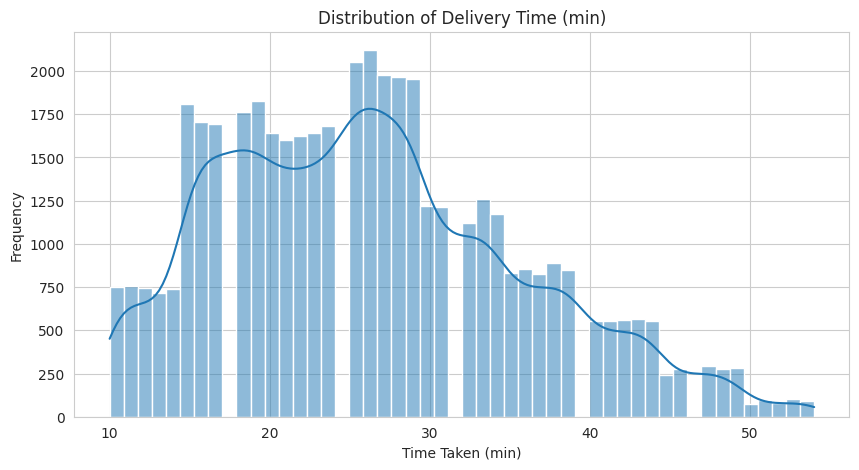

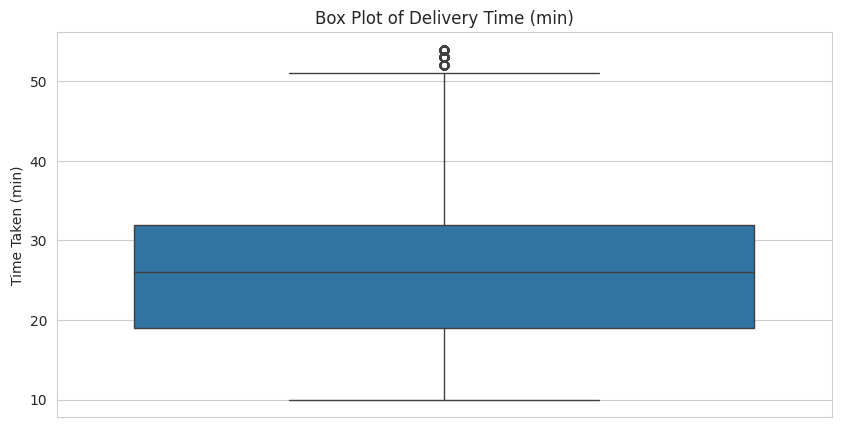

In [ ]:
# --- 3. Graphical EDA (Exploratory Data Analysis) ---
print("\n--- 3. Graphical EDA ---")

# Distribution of Target Variable: Time_taken (min)
plt.figure(figsize=(10, 5))
sns.histplot(df['Time_taken (min)'], kde=True, bins=50)
plt.title('Distribution of Delivery Time (min)')
plt.xlabel('Time Taken (min)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(y=df['Time_taken (min)'])
plt.title('Box Plot of Delivery Time (min)')
plt.ylabel('Time Taken (min)')
plt.show()

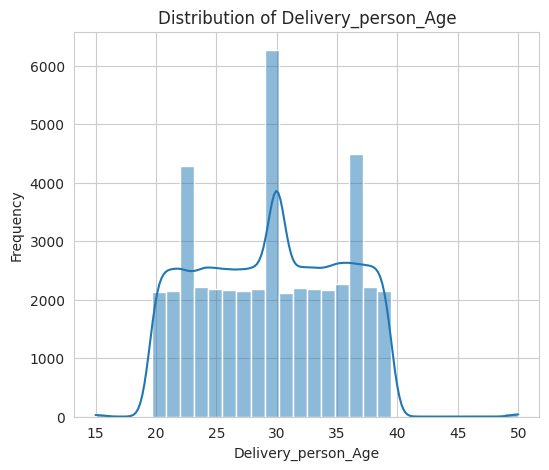

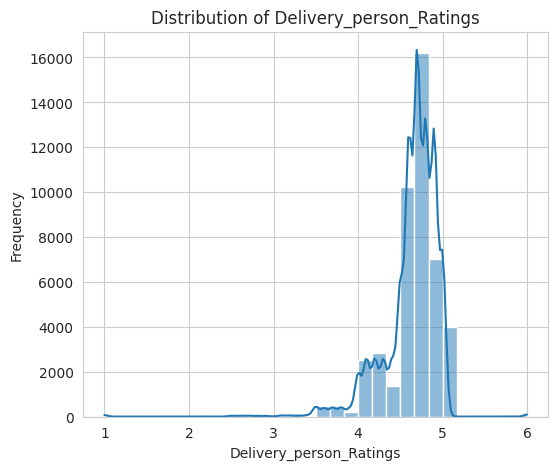

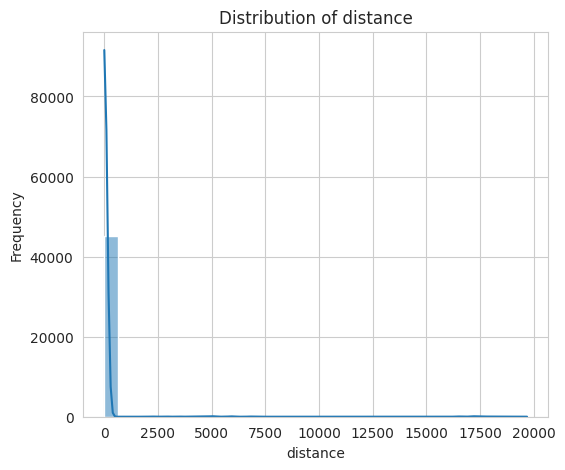

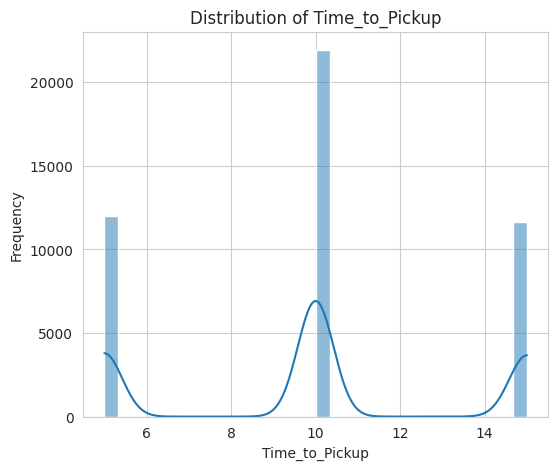

In [ ]:
# Distribution of Key Numerical Features
numerical_features_to_plot = ['Delivery_person_Age', 'Delivery_person_Ratings', 'distance', 'Time_to_Pickup']
for col in numerical_features_to_plot:
    plt.figure(figsize=(6, 5))
    sns.histplot(df[col].dropna(), kde=True, bins=30) # dropna for plotting only if NaNs exist
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

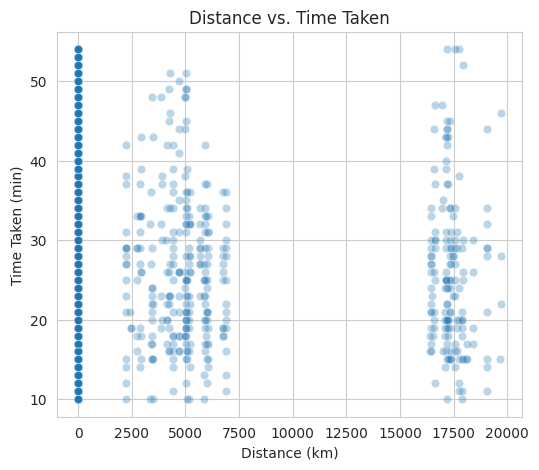

In [ ]:
# Relationship between Distance and Time_taken (min)
plt.figure(figsize=(6,5))
sns.scatterplot(x='distance', y='Time_taken (min)', data=df, alpha=0.3)
plt.title('Distance vs. Time Taken')
plt.xlabel('Distance (km)')
plt.ylabel('Time Taken (min)')
plt.show()

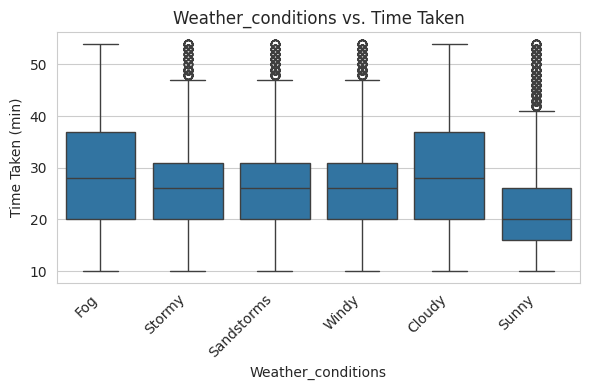

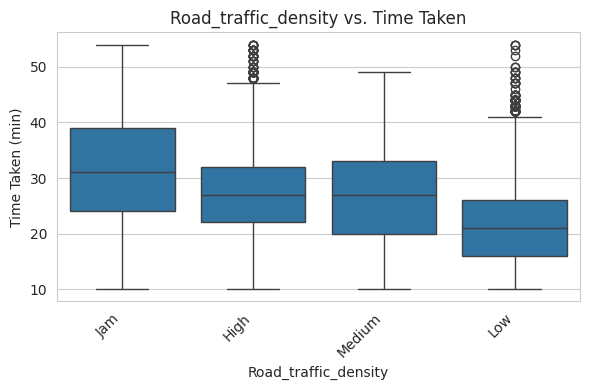

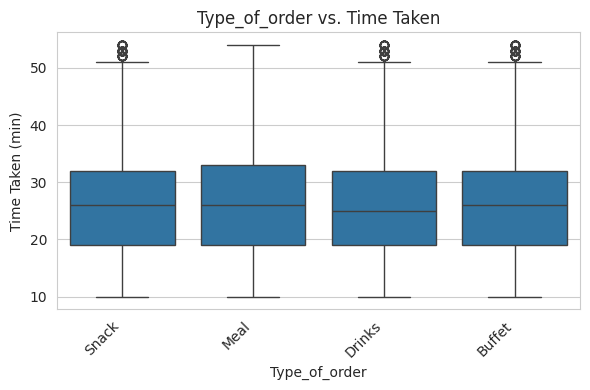

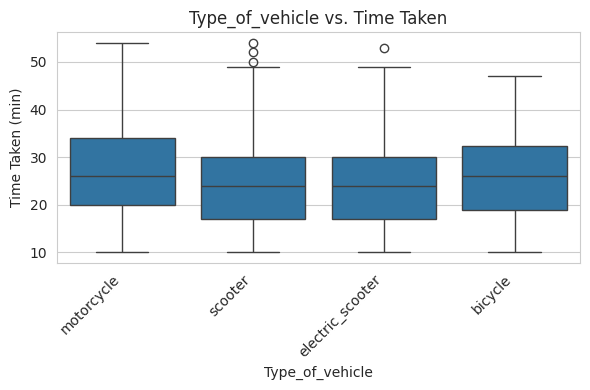

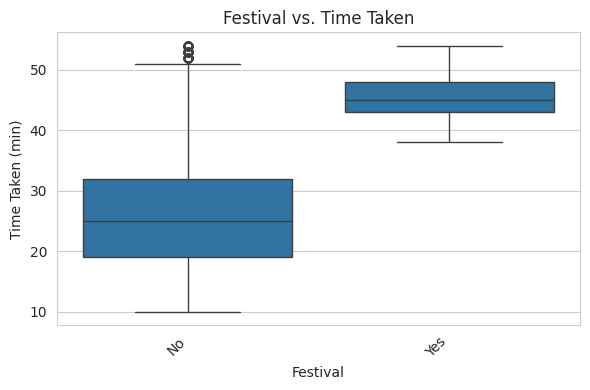

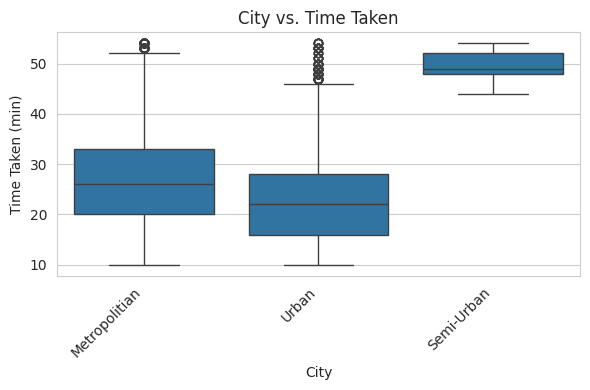

In [ ]:
# Impact of Categorical Features on Time_taken (min)
categorical_features_to_plot = ['Weather_conditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'Festival', 'City']
for col in categorical_features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=col, y='Time_taken (min)', data=df)
    plt.title(f'{col} vs. Time Taken')
    plt.xlabel(col)
    plt.ylabel('Time Taken (min)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

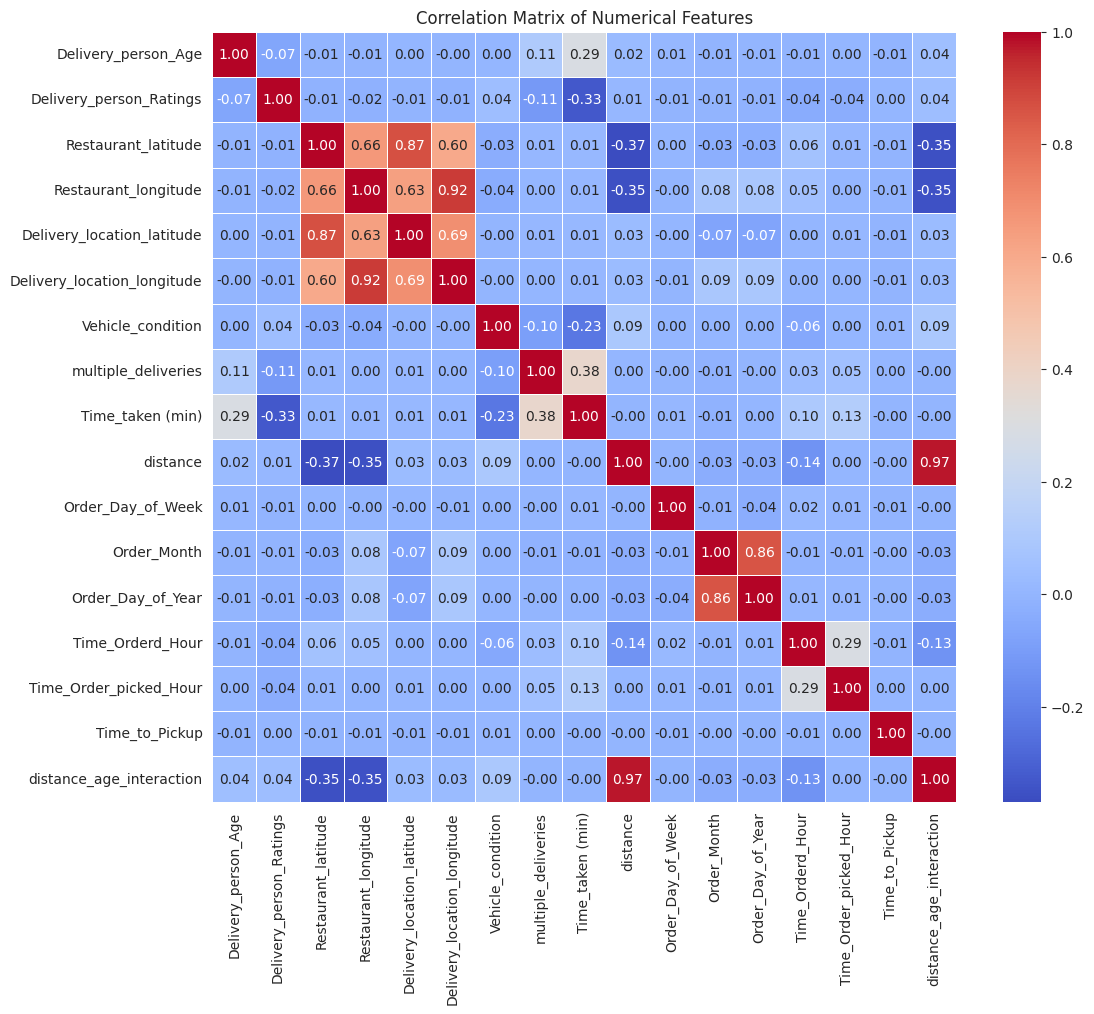

In [ ]:
 #Correlation Matrix of Numerical Features
plt.figure(figsize=(12, 10))
# Select only numerical columns for correlation matrix
correlation_matrix_df = df.select_dtypes(include=np.number)
sns.heatmap(correlation_matrix_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [ ]:
# -- Separate Features (X) and Target (y) and Train-Test Split ---
print("\n--- 5. Separate Features (X) and Target (y) and Train-Test Split ---")
X = df.drop('Time_taken (min)', axis=1)
y = df['Time_taken (min)']


--- 5. Separate Features (X) and Target (y) and Train-Test Split ---


In [ ]:
# Identify categorical and numerical columns for preprocessing pipeline
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (36467, 22)
Shape of X_test: (9117, 22)
Shape of y_train: (36467,)
Shape of y_test: (9117,)


In [ ]:
# --- Preprocessing Pipelines Setup ---
print("\n--- 6. Preprocessing Pipelines Setup ---")
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


--- 6. Preprocessing Pipelines Setup ---


In [ ]:
# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keeps columns not specified (should be none here)
)


In [ ]:
# -- Model: Random Forest Regressor with Hyperparameter Tuning (Randomized Search) ---
print("\n--- Model : Random Forest Regressor with Randomized Search ---")

# Define parameter distribution for RandomizedSearchCV
param_dist_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_features': [0.6, 0.8, 1.0],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}



--- Model : Random Forest Regressor with Randomized Search ---


In [ ]:
# Create a machine learning pipeline for Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', RandomForestRegressor(random_state=42))])

In [ ]:
# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=10,  # Number of parameter settings that are sampled. Reduce for faster execution.
    cv=3,       # Number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1   # Use all available cores
)


In [ ]:
# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist_rf,
    n_iter=5,  # Number of parameter settings that are sampled. Reduce for faster execution.
    cv=3,       # Number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1   # Use all available cores
)


In [ ]:
random_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Vehicle_condition',
       'multiple_deliveries', 'di...
       'Type_of_vehicle', 'Festival', 'City'],
      dtype='object'))])),
                                             ('regressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'regressor__max_depth': [10, 20, 30,
                                                                 None],
                                        'regressor__max_features': [0.6, 0.8,
                                                                    1.0],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10],
                                        'regressor__n_estimators': [100, 200,
                                                                    300]},
                   random_state=42, verbose=1)

In [ ]:
# Evaluate the best Random Forest model
y_pred_rf = random_search_rf.best_estimator_.predict(X_test)
y_pred_rf

array([34.36584833, 25.06450266, 18.63784782, ..., 38.78946671,
       25.54027317, 28.65480819])

In [ ]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R2: {r2_rf:.2f}")

Random Forest MAE: 3.16
Random Forest RMSE: 4.00
Random Forest R2: 0.82


In [ ]:
# ---. Model 2: XGBoost Regressor ---
print("\n--- . Model 2: XGBoost Regressor ---")

# Define an XGBoost Regressor pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=-1))])


--- . Model 2: XGBoost Regressor ---


In [ ]:
# Train the XGBoost model
xgb_pipeline.fit(X_train, y_train)

# Make predictions with XGBoost
y_pred_xgb = xgb_pipeline.predict(X_test)

In [ ]:
# Evaluate the XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R2: {r2_xgb:.2f}")


XGBoost MAE: 3.26
XGBoost RMSE: 4.11
XGBoost R2: 0.81


In [ ]:
# Compare models and select the better one for saving
best_model_pipeline = None
if r2_xgb >= r2_rf:
    best_model_pipeline = xgb_pipeline
    print("\nXGBoost model performed better (higher R2) and will be saved.")
else:
    best_model_pipeline = random_search_rf.best_estimator_
    print("\nRandom Forest model performed better (higher R2) and will be saved.")


Random Forest model performed better (higher R2) and will be saved.



--- 9. Error Analysis for the Best Model ---


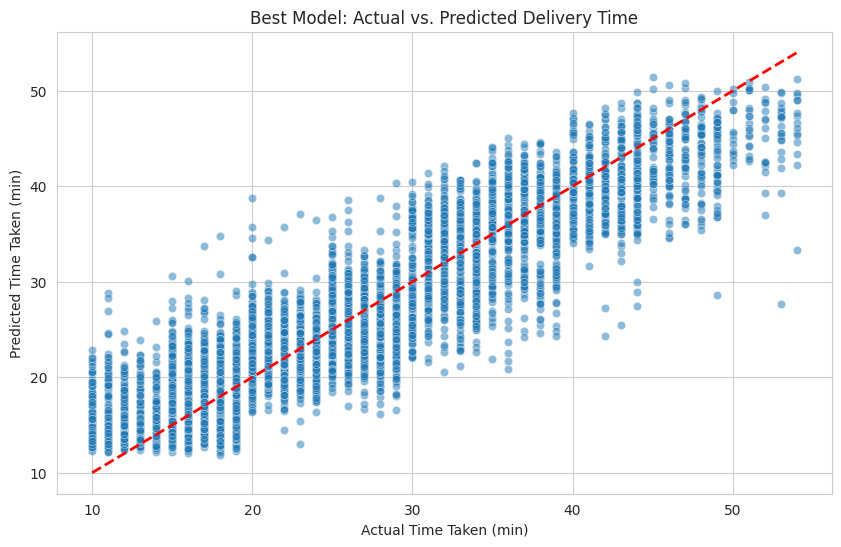

In [ ]:
# --- 9. Error Analysis (for the best performing model) ---
print("\n--- 9. Error Analysis for the Best Model ---")

# Use predictions from the best model chosen above
y_pred_best = best_model_pipeline.predict(X_test)
residuals = y_test - y_pred_best
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5)
plt.title('Best Model: Actual vs. Predicted Delivery Time')
plt.xlabel('Actual Time Taken (min)')
plt.ylabel('Predicted Time Taken (min)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal line
plt.grid(True)
plt.show()

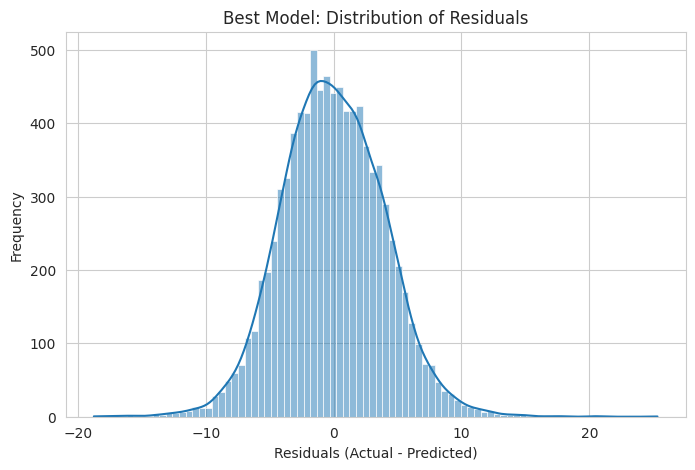

In [ ]:
# Plot histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title('Best Model: Distribution of Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Identify top N largest positive and negative errors
top_n_errors = 10
large_positive_errors = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best, 'Residual': residuals}).nlargest(top_n_errors, 'Residual')
large_negative_errors = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best, 'Residual': residuals}).nsmallest(top_n_errors, 'Residual')

print(f"\nTop {top_n_errors} Largest Positive Errors (Underpredictions - Model Predicted Lower):")
print(large_positive_errors.to_markdown(numalign="left", stralign="left"))

print(f"\nTop {top_n_errors} Largest Negative Errors (Overpredictions - Model Predicted Higher):")
print(large_negative_errors.to_markdown(numalign="left", stralign="left"))


Top 10 Largest Positive Errors (Underpredictions - Model Predicted Lower):
|       | Actual   | Predicted   | Residual   |
|:------|:---------|:------------|:-----------|
| 30884 | 53       | 27.6633     | 25.3367    |
| 3702  | 54       | 33.2913     | 20.7087    |
| 23269 | 49       | 28.5737     | 20.4263    |
| 35155 | 42       | 24.3648     | 17.6352    |
| 6072  | 43       | 25.4434     | 17.5566    |
| 33582 | 44       | 27.5048     | 16.4952    |
| 29333 | 36       | 20.8604     | 15.1396    |
| 23460 | 44       | 28.9242     | 15.0758    |
| 9545  | 52       | 37.0082     | 14.9918    |
| 44936 | 42       | 27.2593     | 14.7407    |

Top 10 Largest Negative Errors (Overpredictions - Model Predicted Higher):
|       | Actual   | Predicted   | Residual   |
|:------|:---------|:------------|:-----------|
| 30529 | 20       | 38.7581     | -18.7581   |
| 25798 | 11       | 28.8059     | -17.8059   |
| 20544 | 11       | 28.2671     | -17.2671   |
| 17720 | 18       | 34.8293    

In [ ]:
# --- . Save the Best Model ---
print("\n---. Saving the Best Model ---")
joblib.dump(best_model_pipeline, 'delivery_time_prediction_model.pkl')
print("Best performing model saved as 'delivery_time_prediction_model.pkl'")




---. Saving the Best Model ---
Best performing model saved as 'delivery_time_prediction_model.pkl'


In [ ]:
import folium
folium.Map(title="cartodb positron")


In [ ]:
import folium
from branca.element import Figure
fig2=Figure(width=850,height=550)

In [ ]:
# Create a map object centered on a specific location
m = folium.Map(location=[30.914057, 75.83982], zoom_start=12)

# Add a marker for the restaurant location
folium.Marker(location=[30.914057, 75.83982], popup="Restaurant",icon=folium.Icon(color='purple',prefix='fa',icon='anchor')).add_to(m)

# Add a marker for the delivery location
folium.Marker(location=[30.924057, 75.84982], popup="Delivery").add_to(m)

# Draw a line between the two locations
folium.PolyLine(locations=[[30.914057, 75.83982], [30.924057, 75.84982]], color='red').add_to(m)



In [ ]:
fig2.add_child(m)

In [ ]:
try:
    loaded_model = joblib.load('delivery_time_prediction_model.pkl')
    print("Model 'delivery_time_prediction_model.pkl' loaded successfully!")

    # Prepare a new sample data point (MUST match the original feature columns)
    # Ensure all original columns, including newly engineered ones, are present
    # except 'Time_taken (min)'.
    sample_new_data = {
        'Delivery_person_Age': 25.0,
        'Delivery_person_Ratings': 4.7,
        'Restaurant_latitude': 18.5624,
        'Restaurant_longitude': 73.9166,
        'Delivery_location_latitude': 18.6525,
        'Delivery_location_longitude': 74.0066,
        'Weather_conditions': 'Sunny',
        'Road_traffic_density': 'Low',
        'Vehicle_condition': 1,
        'Type_of_order': 'Meal',
        'Type_of_vehicle': 'scooter',
        'multiple_deliveries': 1.0,
        'Festival': 'No',
        'City': 'Metropolitian',
        'Order_Day_of_Week': 2,
        'Order_Month': 5,
        'Order_Day_of_Year': 135,
        'Time_Orderd_Hour': 14,
        'Time_Order_picked_Hour': 14,
        'Time_to_Pickup': 10.0, # Assuming this was derived from actual times
        'distance': haversine(18.5624, 73.9166, 18.6525, 74.0066), # Re-calculate
        'distance_age_interaction': haversine(18.5624, 73.9166, 18.6525, 74.0066) * 25.0 # Re-calculate
    }

    # Convert to DataFrame, ensuring order of columns (though pipeline handles it based on names)
    sample_df_for_prediction = pd.DataFrame([sample_new_data])

    # Make prediction
    predicted_delivery_time = loaded_model.predict(sample_df_for_prediction)

    print(f"Predicted delivery time for the sample data: {predicted_delivery_time[0]:.2f} minutes")

except Exception as e:
    print(f"An error occurred during model loading or prediction: {e}")



Model 'delivery_time_prediction_model.pkl' loaded successfully!
Predicted delivery time for the sample data: 26.89 minutes
